In [ ]:
#Fetching Breast Cancer Wisconsin (Diagnostic) Dataset
!pip install ucimlrepo
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

#dataset
df = fetch_ucirepo(id=17)

#assigning features and target to X and y
X = df.data.features
y = df.data.targets



In [45]:
type(df)

ucimlrepo.dotdict.dotdict

In [ ]:
print("Rows: ", X.shape[0], '\n',"Columns:", y.shape[1])
X.head()

Rows:  569 
 Columns: 1


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [51]:
#X.columns.tolist()
#X.describe()
#X.isnull().sum()
y.isnull().sum()

np.int64(0)

In [42]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score



# --- ORIG MODEL trained on all 30 features ---
#Goal: eval SVM perf on classifying the data before reducing dimensions to visualize


pipe = Pipeline([           ##runs scaler and SVC in a stack
("scaler", StandardScaler()),
("svc", SVC(kernel="linear", C=5))
])

#kFOld
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#SCORING: ROC AND RECALL
scores = {
    "roc_auc": "roc_auc",
    "recall_M": make_scorer(recall_score, pos_label="M")
}

cv_results = cross_validate(pipe, X, y, cv=cv, scoring=scores) ##runs stack and scores

print("Mean SVM ROC-AUC:", cv_results["test_roc_auc"].mean())
print("Mean SVM Recall (M):", cv_results["test_recall_M"].mean(),'\n') #important for minimizing false negatives - missed M diagnoses



Mean SVM ROC-AUC: 0.991955089711395
Mean SVM Recall (M): 0.9481727574750829 



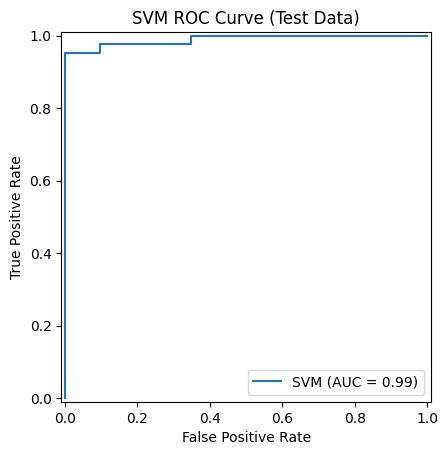

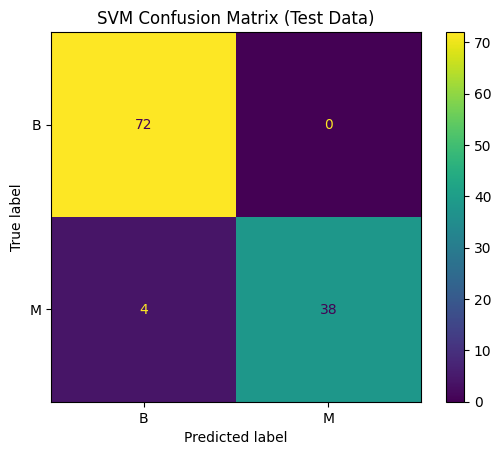

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# split for ROC curve + confusion matrix
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train) #still uses scale+SVM stack

# ROC
y_score = pipe.decision_function(X_test) #boundary sep

# M = Positive class
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label="M")
roc_auc = auc(fpr, tpr)

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="SVM").plot()
plt.title("SVM ROC Curve (Test Data)")
plt.show()

# Confusion matrix
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=["B", "M"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["B", "M"])
disp.plot()
plt.title("SVM Confusion Matrix (Test Data)")
plt.show()


Reduced SVC weights:  [ 1.06140112 -0.5512921 ]


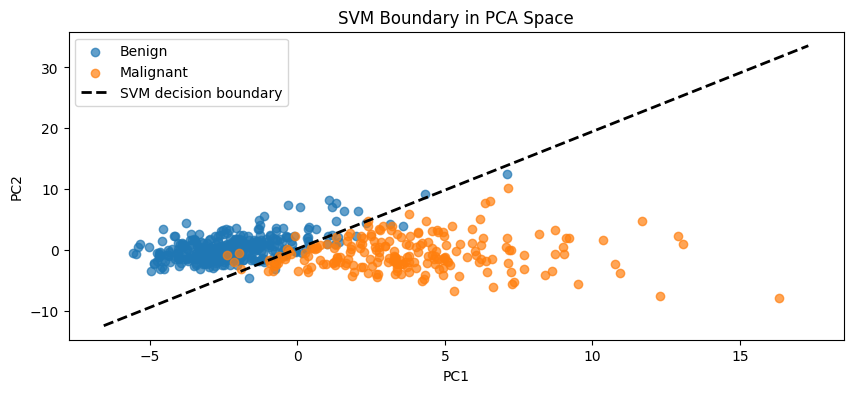

In [35]:
#--- scale and reduce Dim for plotting separation boundary (new 2dim model) ---

y = y.squeeze()  #DF to series

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42) #2 PCs needed to plot
X_pca = pca.fit_transform(X_scaled)
#print('X Reduced Dimensions: ', X_pca.shape)

#New SVC model
C = 5
model = SVC(kernel="linear", C=.1, class_weight="balanced") #EDIT: added class_weight since classes are unequal - better performance
model.fit(X_pca, y)   #reduced X: shape (569,2) - PCA worked

coefs = model.coef_[0]   #shape (2,) , model weights after PCA
#print(coefs.shape)
print("Reduced SVC weights: ", coefs)

#---PCA plot---

#save SVM weights
w0, w1 = model.coef_[0]
b = model.intercept_[0]

#x-range
x_vals = np.array([
    X_pca[:, 0].min() - 1,
    X_pca[:, 0].max() + 1
])

# decision boundary: PC2 = m*PC1 + c
y_vals = -(w0 / w1) * x_vals - (b / w1)

plt.figure(figsize=(10, 4))

plt.scatter(X_pca[y == "B", 0], X_pca[y == "B", 1],
    alpha=0.7, label="Benign")

plt.scatter(X_pca[y == "M", 0], X_pca[y == "M", 1],
    alpha=0.7, label="Malignant")

plt.plot(x_vals, y_vals,"k--", linewidth=2, label="SVM decision boundary")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('SVM Boundary in PCA Space')
plt.legend()
plt.show()


In [32]:
#class counts
print("unique y:", y.unique())
print(y.value_counts())

# print("type(X_pca):", type(X_pca), "shape:", X_pca.shape)
# print("type(y):", type(y), "shape:", getattr(y, "shape", None))


unique y: ['M' 'B']
Diagnosis
B    357
M    212
Name: count, dtype: int64
